In [88]:
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


In [89]:
mantto = pd.read_csv("Mantenimiento Industrial.csv")

In [90]:
mantto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID_Mantenimiento          50 non-null     int64 
 1   Fecha                     50 non-null     object
 2   Equipo                    50 non-null     object
 3   Componentes_Reemplazados  50 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.7+ KB


In [91]:
mantto.columns = [col.lower() for col in mantto.columns]

print(mantto.head())

   id_mantenimiento       fecha            equipo  \
0                 1  05/01/2023  Bomba_Hidráulica   
1                 2  08/01/2023         Compresor   
2                 3  12/01/2023   Motor_Eléctrico   
3                 4  15/01/2023  Bomba_Hidráulica   
4                 5  20/01/2023         Compresor   

                          componentes_reemplazados  
0          Filtro_Aceite,Sello_Mecánico,Rodamiento  
1                   Filtro_Aire,Correa_Transmisión  
2    Rodamiento,Escobillas,Ventilador_Enfriamiento  
3                   Sello_Mecánico,Válvula_Control  
4  Filtro_Aire,Válvula_Retención,Aceite_Lubricante  


In [92]:
print(mantto.isnull().sum())

id_mantenimiento            0
fecha                       0
equipo                      0
componentes_reemplazados    0
dtype: int64


In [93]:
mantto.duplicated().sum()

np.int64(0)

In [94]:
conteo_equipos = mantto['equipo'].value_counts()
print(conteo_equipos)

equipo
Compresor               12
Motor_Eléctrico         12
Bomba_Hidráulica         9
Bomba_Centrífuga         7
Válvula_Control          5
Cinta_Transportadora     5
Name: count, dtype: int64


Convertiremos la columna "fecha" a formato 'datetime', para poder trabajar con ella

In [95]:
mantto['fecha'] = pd.to_datetime(mantto['fecha'], format='%d/%m/%Y')
print(mantto.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id_mantenimiento          50 non-null     int64         
 1   fecha                     50 non-null     datetime64[ns]
 2   equipo                    50 non-null     object        
 3   componentes_reemplazados  50 non-null     object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.7+ KB
None


Realizaremos la transformación de cadena de texto a lista la columna 'componentes_reemplazados' 

In [96]:
mantto['componente_lista'] = mantto['componentes_reemplazados'].str.split(',')

convertiremos la columna çomponente_lista´a varias filas de cada componente

In [97]:
refacciones = mantto.explode('componente_lista').copy()
print(refacciones.head())

   id_mantenimiento      fecha            equipo  \
0                 1 2023-01-05  Bomba_Hidráulica   
0                 1 2023-01-05  Bomba_Hidráulica   
0                 1 2023-01-05  Bomba_Hidráulica   
1                 2 2023-01-08         Compresor   
1                 2 2023-01-08         Compresor   

                  componentes_reemplazados    componente_lista  
0  Filtro_Aceite,Sello_Mecánico,Rodamiento       Filtro_Aceite  
0  Filtro_Aceite,Sello_Mecánico,Rodamiento      Sello_Mecánico  
0  Filtro_Aceite,Sello_Mecánico,Rodamiento          Rodamiento  
1           Filtro_Aire,Correa_Transmisión         Filtro_Aire  
1           Filtro_Aire,Correa_Transmisión  Correa_Transmisión  


Relizaremos una limpieza a la nueva fila 'componente_lista' eliminando espacios y conviertiendo las filas todo a minusculas para evitar duplicados

In [98]:
refacciones['componentes'] = refacciones['componente_lista'].str.strip().str.lower()

Vamos a calcular cuanto tiempo ha trascurrido entre un mantenimiento y otro de cada equipo.

In [99]:
mantto = mantto.sort_values(by=['equipo', 'fecha'])
mantto['tme_f'] = mantto.groupby('equipo')['fecha'].diff()
print(mantto['tme_f'].head())

6        NaT
13   28 days
18   18 days
26   36 days
34   35 days
Name: tme_f, dtype: timedelta64[ns]


Convertiremos el formato tiempo a número entero de días y realizaremos la eliminación de la columna 'tme_f'

In [100]:
mantto['dias_hasta_falla'] = mantto['tme_f'].dt.days
mantto = mantto.drop(columns=['tme_f'])

EMPEZAREMOS A PREPARAR LOS DATOS PARA REALIZAR UN ANALISIS CON MACHINE LEARNING

Convertiremos la columna 'equipo' en un formato de '0 y 1' usando la funcion de pandas "dummies"
 para que ML pueda procesar esta información sin errores de orden.
 Uniremos la nueva 'tabla' con nuestra base de datos'mantto'
 y eliminaremos la columna 'equipo' de nuestra base de datos

In [101]:
codificacion_equipos = pd.get_dummies(mantto['equipo'], prefix='equipo')
mantto = pd.concat([mantto, codificacion_equipos], axis=1)
mantto = mantto.drop('equipo', axis=1)

mantto = mantto.dropna(subset=['dias_hasta_falla'])


Ahora dividiremos los datos en dos grupos 

Selección de Entradas (X) y Salida (Y)

In [102]:
Y = mantto['dias_hasta_falla']

X = mantto.drop(columns=['id_mantenimiento', 'fecha', 'componentes_reemplazados', 'componente_lista', 'dias_hasta_falla'])

In [103]:
X_entrenamiento, X_prueba, Y_entrenamiento, Y_prueba = train_test_split(
    X, 
    Y, 
    test_size=0.2, 
    random_state=42)

Usaremos el modelo de "Árbol de Decisión para Regresión" (ya que estamos prediciendo un número, los días).

In [104]:
modelo_arbol = DecisionTreeRegressor(random_state=42)
modelo_arbol.fit(X_entrenamiento, Y_entrenamiento)

DecisionTreeRegressor(random_state=42)

In [105]:
predicciones = modelo_arbol.predict(X_prueba)
mae = mean_absolute_error(Y_prueba, predicciones)
print(f"El Error Absoluto Medio (MAE) es de: {mae:.2f} días")

El Error Absoluto Medio (MAE) es de: 3.54 días


Ahora Usaremos el Modelo "RandomForest"

In [106]:
modelo_bosque = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_bosque.fit(X_entrenamiento, Y_entrenamiento)
predicciones_bosque = modelo_bosque.predict(X_prueba)

mae_bosque = mean_absolute_error(Y_prueba, predicciones_bosque)

print(f"El MAE del Árbol de Decisión fue: 3.54 días")
print(f"El MAE del Random Forest (Bosque Aleatorio) es de: {mae_bosque:.2f} días")

El MAE del Árbol de Decisión fue: 3.54 días
El MAE del Random Forest (Bosque Aleatorio) es de: 3.40 días


Vamos a Generar un Gráfico de dispersión para visualizar estos resultados

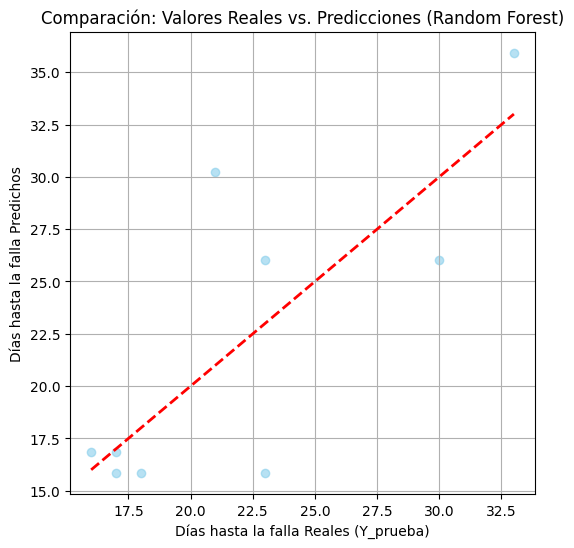

In [108]:
plt.figure(figsize=(6, 6))

plt.scatter(Y_prueba, predicciones_bosque, alpha=0.6, color='skyblue')
plt.plot([Y_prueba.min(), Y_prueba.max()], [Y_prueba.min(), Y_prueba.max()], 
         '--r', linewidth=2)

plt.title('Comparación: Valores Reales vs. Predicciones (Random Forest)')
plt.xlabel('Días hasta la falla Reales (Y_prueba)')
plt.ylabel('Días hasta la falla Predichos')
plt.grid(True)
plt.show()

El gráfico nos muestra qué tan bien realiza las predicciones nuestro modelo la fecha de falla. 
La línea roja es la predicción perfecta donde el modelo acierta al 100%. Cada punto azul es una de las fallas que el modelo intentó predecir. C
omo la mayoría de los puntos azules están muy cerca de la línea roja, significa que el modelo es confiable.
La distancia promedio de esos puntos a la línea es de solo 3.40 días, que es el error que arrojó el modelo.

Vamos a analizar para obtener cuales equipos son los más importantes en la predicción de las fallas

In [109]:
importancias = modelo_bosque.feature_importances_

importancia_df = pd.DataFrame({'Variable': X.columns, 'Importancia': importancias})
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)

print("Importancia de las Variables para la Predicción:")
print(importancia_df.head(5))

Importancia de las Variables para la Predicción:
                      Variable  Importancia
4       equipo_Motor_Eléctrico     0.273282
3             equipo_Compresor     0.261511
2  equipo_Cinta_Transportadora     0.152463
5       equipo_Válvula_Control     0.116562
1      equipo_Bomba_Hidráulica     0.115058


Vamos a generar un Gráfico de barras para visualizar estos datos

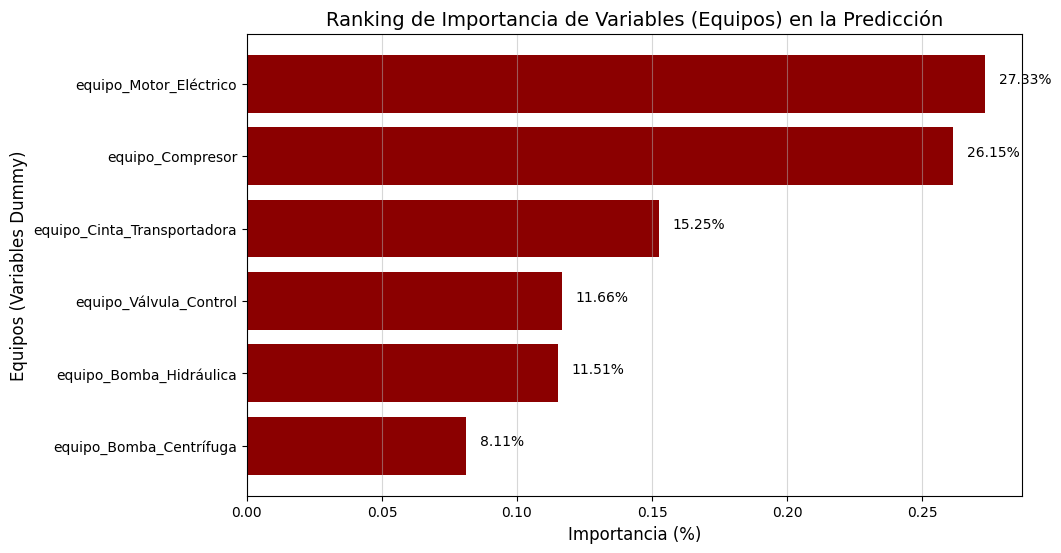

In [110]:
importancia_df_ordenada = importancia_df.sort_values(by='Importancia', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importancia_df_ordenada['Variable'], importancia_df_ordenada['Importancia'], color='darkred')

plt.title('Ranking de Importancia de Variables (Equipos) en la Predicción', fontsize=14)
plt.xlabel('Importancia (%)', fontsize=12)
plt.ylabel('Equipos (Variables Dummy)', fontsize=12)


for index, value in enumerate(importancia_df_ordenada['Importancia']):
    plt.text(value + 0.005, index, f'{value*100:.2f}%') 
plt.grid(axis='x', alpha=0.5)
plt.show()

El modelo nos dice que el patrón de fallas en la planta está dominado por solo dos equipos: el Motor Eléctrico y el Compresor. 
Estos dos equipos juntos determinan más de la mitad del resultado de la predicción de fallas. 
Esto significa que si se quiere reducir el error de o mejorar la estabilidad de la operación, la inversión en sensores, monitoreo o mantenimiento predictivo debe enfocarse principalmente en estos dos activos, ya que son los que causan la mayor variación en los tiempos de falla. 
Los otros equipos son menos importantes para la predicción, lo que sugiere que sus fallas son más rutinarias y predecibles.

Generaremos un g´rafico Histograma de "dias de falla"

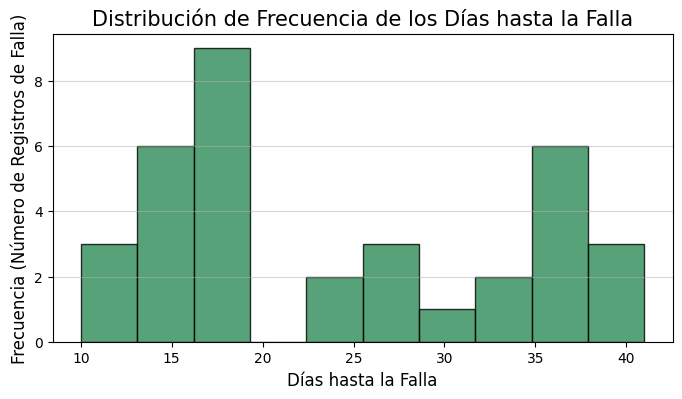

In [112]:
plt.figure(figsize=(8, 4))
plt.hist(Y_entrenamiento, bins=10, edgecolor='black', color='seagreen', alpha=0.8)

plt.title('Distribución de Frecuencia de los Días hasta la Falla', fontsize=15)
plt.xlabel('Días hasta la Falla', fontsize=12)
plt.ylabel('Frecuencia (Número de Registros de Falla)', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()

Esto nos dice que, si bien la falla promedio es mayor, el periodo de mayor riesgo y la ventana donde ocurre la mayor cantidad de fallas es durante la tercera semana (15-20 días) después del último mantenimiento. 
Este es el tiempo donde se debe estar más atento.

Guardaremos el Modelo para 

In [113]:
import joblib

joblib.dump(modelo_bosque, 'modelo_random_forest_TMEF.joblib')

print("✅ ¡Modelo guardado exitosamente!")

✅ ¡Modelo guardado exitosamente!
